<a href="https://colab.research.google.com/github/sharvaniyadav/ECE1513-Final-Project/blob/main/ECE1513FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECE1513 FINAL PROJECT**

In [1]:
# Cell 1: Setup, Imports, Reproducibility

# Imported basic utilities
import os
import zipfile
import random

# Imported numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# Imported PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Imported Torchvision for datasets and models
from torchvision import datasets, transforms, models

# Imported evaluation tools
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Selected device (GPU when available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Defined project constants
image_size = 224
batch_size = 32
num_classes = 3

# Defined ImageNet normalization stats for EfficientNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

print("Setup completed. Ready to load data.")

Using device: cuda
Setup completed. Ready to load data.


In [2]:
# Cell 2: Loaded and prepared the dataset

# Set the path to the uploaded zip file
zip_path = "/content/Data.zip"

# Unzipped the dataset into /content/
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall("/content/")
    print("Data.zip was extracted successfully.")
else:
    print("Data.zip was not found. I needed to upload it to Colab first.")

# Defined the dataset root directory
data_root = "/content/Data"
print("Dataset root existed:", os.path.exists(data_root))

# Listed the contents to confirm the expected folders
if os.path.exists(data_root):
    print("Root contents:", os.listdir(data_root))


Data.zip was extracted successfully.
Dataset root existed: True
Root contents: ['valid', 'train', 'test']


Train directory existed: True
Valid directory existed: True
Test directory existed: True
Train counts: {'crack': 676, 'missing-head': 661, 'paint-off': 605} | Total: 1942
Valid counts: {'crack': 175, 'missing-head': 169, 'paint-off': 87} | Total: 431
Test counts: {'crack': 211, 'missing-head': 200, 'paint-off': 128} | Total: 539


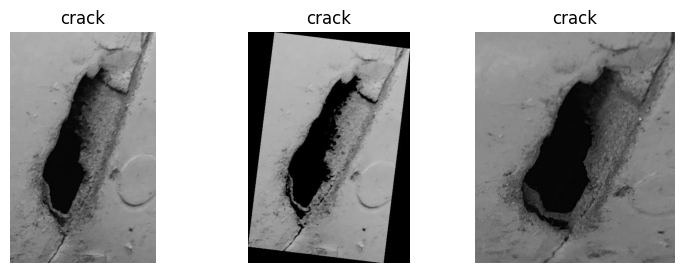

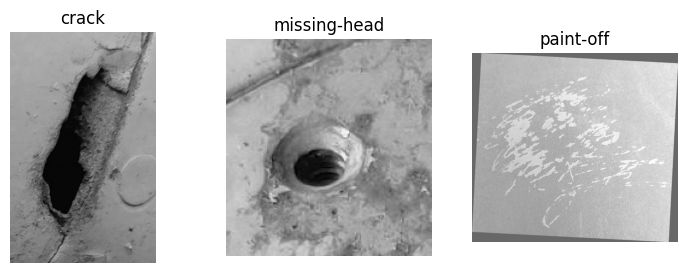

In [3]:
# Cell 3: Inspected dataset structure and sample images

# Checked that the split directories existed
train_dir = os.path.join(data_root, "train")
valid_dir = os.path.join(data_root, "valid")
test_dir  = os.path.join(data_root, "test")

print("Train directory existed:", os.path.exists(train_dir))
print("Valid directory existed:", os.path.exists(valid_dir))
print("Test directory existed:", os.path.exists(test_dir))

# Counted images in each class folder
def count_images(folder_path):
    counts = {}
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        num_imgs = len([f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        counts[cls] = num_imgs
        total += num_imgs
    return counts, total

train_counts, train_total = count_images(train_dir)
valid_counts, valid_total = count_images(valid_dir)
test_counts, test_total   = count_images(test_dir)

print("Train counts:", train_counts, "| Total:", train_total)
print("Valid counts:", valid_counts, "| Total:", valid_total)
print("Test counts:", test_counts, "| Total:", test_total)

# Loaded the training dataset for visualization
sample_ds = datasets.ImageFolder(train_dir, transform=transforms.ToTensor())

# Displayed the first three samples
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes):
    img, label = sample_ds[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(sample_ds.classes[label])
    ax.axis("off")
plt.show()

# Displayed one example from each class
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for idx, cls in enumerate(sample_ds.classes):
    class_idx = sample_ds.class_to_idx[cls]
    first_index = next(i for i, (_, label) in enumerate(sample_ds) if label == class_idx)

    img, label = sample_ds[first_index]
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(cls)
    axes[idx].axis("off")

plt.show()

In [4]:
# Cell 4: Defined transforms and created dataloaders

# Defined basic constants for preprocessing
image_size = 224
batch_size = 32
num_classes = 3

# Defined ImageNet normalization stats for EfficientNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Defined training transforms with augmentation
train_tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Defined validation and test transforms without augmentation
eval_tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Loaded datasets with transforms applied
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
valid_ds = datasets.ImageFolder(valid_dir, transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir, transform=eval_tfms)

# Created dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Printed dataset sizes and class names
print("Train size:", len(train_ds))
print("Valid size:", len(valid_ds))
print("Test size:", len(test_ds))
print("Class names:", train_ds.classes)

Train size: 1942
Valid size: 431
Test size: 539
Class names: ['crack', 'missing-head', 'paint-off']


In [5]:
# Cell 5: Built the baseline CNN model

# Defined a simple baseline CNN [Convolutional Neural Network] from scratch
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # Set up the feature extractor part
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Set up the classifier part
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Created the baseline model and moved it to the selected device
baseline_model = BaselineCNN(num_classes=num_classes).to(device)

# Printed the model to confirm the layers
print(baseline_model)

BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [6]:
# Cell 6: Trained and validated the baseline CNN

# Defined the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=1e-3)

# Set the number of epochs for the baseline model
baseline_epochs = 15

# Stored training history for plotting later
baseline_history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

# Trained the model epoch by epoch
for epoch in range(baseline_epochs):

    # Training phase
    baseline_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / total_train
    train_acc = correct_train / total_train

    # Validation phase
    baseline_model.eval()
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = baseline_model(images)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct_valid += (preds == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss = running_valid_loss / total_valid
    valid_acc = correct_valid / total_valid

    # Saved results for plotting
    baseline_history["train_loss"].append(train_loss)
    baseline_history["train_acc"].append(train_acc)
    baseline_history["valid_loss"].append(valid_loss)
    baseline_history["valid_acc"].append(valid_acc)

    # Printed progress for this epoch
    print(
        f"Epoch {epoch+1}/{baseline_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
    )

# Saved the trained baseline model
torch.save(baseline_model.state_dict(), "baseline_cnn.pt")
print("Baseline model training finished and model was saved as baseline_cnn.pt.")

Epoch 1/15 | Train Loss: 1.0192, Train Acc: 0.5381 | Valid Loss: 0.7776, Valid Acc: 0.6520
Epoch 2/15 | Train Loss: 0.7277, Train Acc: 0.6617 | Valid Loss: 0.6834, Valid Acc: 0.7262
Epoch 3/15 | Train Loss: 0.6578, Train Acc: 0.6972 | Valid Loss: 0.6775, Valid Acc: 0.7123
Epoch 4/15 | Train Loss: 0.6320, Train Acc: 0.7250 | Valid Loss: 0.6400, Valid Acc: 0.7239
Epoch 5/15 | Train Loss: 0.6099, Train Acc: 0.7188 | Valid Loss: 0.6327, Valid Acc: 0.7169
Epoch 6/15 | Train Loss: 0.5765, Train Acc: 0.7472 | Valid Loss: 0.6064, Valid Acc: 0.7541
Epoch 7/15 | Train Loss: 0.5650, Train Acc: 0.7549 | Valid Loss: 0.6875, Valid Acc: 0.7216
Epoch 8/15 | Train Loss: 0.5600, Train Acc: 0.7611 | Valid Loss: 0.6148, Valid Acc: 0.7425
Epoch 9/15 | Train Loss: 0.5238, Train Acc: 0.7755 | Valid Loss: 0.6214, Valid Acc: 0.7610
Epoch 10/15 | Train Loss: 0.4966, Train Acc: 0.7858 | Valid Loss: 0.6153, Valid Acc: 0.7749
Epoch 11/15 | Train Loss: 0.4641, Train Acc: 0.8105 | Valid Loss: 0.6437, Valid Acc: 0.75

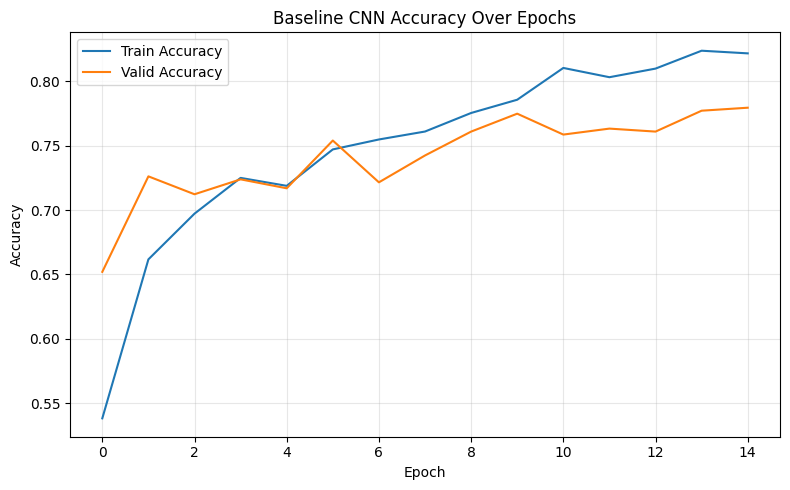

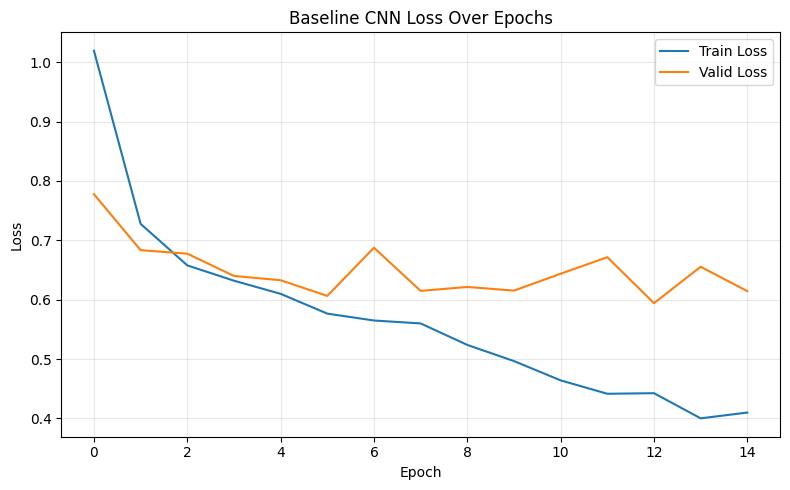

Baseline performance plots were generated and saved as PNG files.


In [7]:
# Cell 7: Plotted training and validation performance for the baseline CNN

# Created accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(baseline_history["train_acc"], label="Train Accuracy")
plt.plot(baseline_history["valid_acc"], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline CNN Accuracy Over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("baseline_accuracy.png")
plt.show()

# Created loss plot
plt.figure(figsize=(8, 5))
plt.plot(baseline_history["train_loss"], label="Train Loss")
plt.plot(baseline_history["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline CNN Loss Over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("baseline_loss.png")
plt.show()

print("Baseline performance plots were generated and saved as PNG files.")

In [8]:
# Cell 8: Set up EfficientNetB0 transfer learning model

# Loaded a pretrained EfficientNetB0 model
eff_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replaced the classifier head so it matched my 3 classes
in_features = eff_model.classifier[1].in_features
eff_model.classifier[1] = nn.Linear(in_features, num_classes)

# Froze the feature extractor first so only the new head trained
for param in eff_model.features.parameters():
    param.requires_grad = False

# Moved the model to the selected device
eff_model = eff_model.to(device)

# Printed the model classifier to confirm the change
print("EfficientNet classifier head was replaced with 3 outputs.")
print(eff_model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]

EfficientNet classifier head was replaced with 3 outputs.
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [9]:
# Cell 9: Trained and validated EfficientNetB0 transfer learning model

# Set up loss function for multi class classification
criterion = nn.CrossEntropyLoss()

# Phase 1: trained only the classifier head (backbone was frozen)
head_epochs = 5
head_optimizer = optim.AdamW(eff_model.classifier.parameters(), lr=1e-3)

eff_history_head = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

for epoch in range(head_epochs):

    # Training phase
    eff_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        head_optimizer.zero_grad()
        outputs = eff_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        head_optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / total_train
    train_acc = correct_train / total_train

    # Validation phase
    eff_model.eval()
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = eff_model(images)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct_valid += (preds == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss = running_valid_loss / total_valid
    valid_acc = correct_valid / total_valid

    eff_history_head["train_loss"].append(train_loss)
    eff_history_head["train_acc"].append(train_acc)
    eff_history_head["valid_loss"].append(valid_loss)
    eff_history_head["valid_acc"].append(valid_acc)

    print(
        f"Head Epoch {epoch+1}/{head_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
    )

# Phase 2: unfroze the last two EfficientNet feature blocks and fine tuned
for param in eff_model.features[-2:].parameters():
    param.requires_grad = True

ft_epochs = 8
ft_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, eff_model.parameters()), lr=2e-4)
ft_scheduler = optim.lr_scheduler.StepLR(ft_optimizer, step_size=3, gamma=0.5)

eff_history_ft = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

best_valid_acc = 0.0

for epoch in range(ft_epochs):

    # Training phase
    eff_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        ft_optimizer.zero_grad()
        outputs = eff_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ft_optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / total_train
    train_acc = correct_train / total_train

    # Validation phase
    eff_model.eval()
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = eff_model(images)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct_valid += (preds == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss = running_valid_loss / total_valid
    valid_acc = correct_valid / total_valid

    eff_history_ft["train_loss"].append(train_loss)
    eff_history_ft["train_acc"].append(train_acc)
    eff_history_ft["valid_loss"].append(valid_loss)
    eff_history_ft["valid_acc"].append(valid_acc)

    ft_scheduler.step()

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(eff_model.state_dict(), "efficientnet_ft.pt")

    print(
        f"FT Epoch {epoch+1}/{ft_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
    )

print("EfficientNet transfer learning training finished and best model was saved as efficientnet_ft.pt.")

Head Epoch 1/5 | Train Loss: 0.7360, Train Acc: 0.7122 | Valid Loss: 0.5752, Valid Acc: 0.7981
Head Epoch 2/5 | Train Loss: 0.4995, Train Acc: 0.8162 | Valid Loss: 0.4770, Valid Acc: 0.8399
Head Epoch 3/5 | Train Loss: 0.4303, Train Acc: 0.8409 | Valid Loss: 0.4437, Valid Acc: 0.8399
Head Epoch 4/5 | Train Loss: 0.4003, Train Acc: 0.8517 | Valid Loss: 0.4296, Valid Acc: 0.8306
Head Epoch 5/5 | Train Loss: 0.3792, Train Acc: 0.8548 | Valid Loss: 0.4158, Valid Acc: 0.8422
FT Epoch 1/8 | Train Loss: 0.3185, Train Acc: 0.8697 | Valid Loss: 0.3218, Valid Acc: 0.8794
FT Epoch 2/8 | Train Loss: 0.2266, Train Acc: 0.9186 | Valid Loss: 0.2853, Valid Acc: 0.8886
FT Epoch 3/8 | Train Loss: 0.1932, Train Acc: 0.9289 | Valid Loss: 0.2821, Valid Acc: 0.8840
FT Epoch 4/8 | Train Loss: 0.1558, Train Acc: 0.9444 | Valid Loss: 0.2482, Valid Acc: 0.9002
FT Epoch 5/8 | Train Loss: 0.1325, Train Acc: 0.9562 | Valid Loss: 0.2488, Valid Acc: 0.9026
FT Epoch 6/8 | Train Loss: 0.1282, Train Acc: 0.9557 | Valid

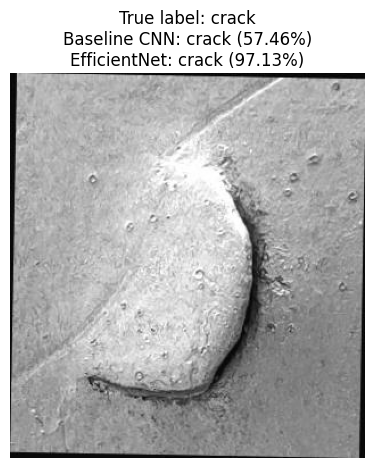

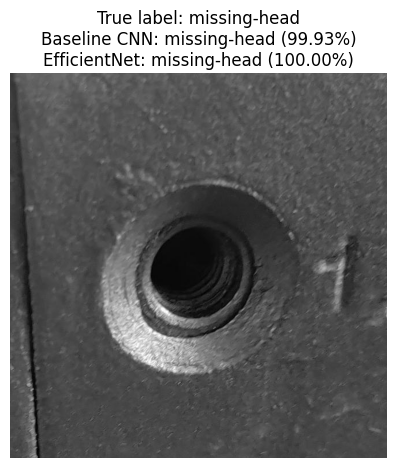

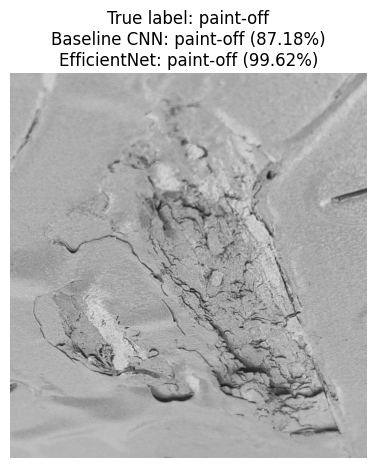

In [10]:
# Cell 10: Tested baseline CNN and EfficientNet on 3 sample test images

# Loaded the saved baseline model
baseline_model.load_state_dict(torch.load("baseline_cnn.pt", map_location=device))
baseline_model.eval()

# Loaded the saved EfficientNet model (fine-tuned)
eff_model.load_state_dict(torch.load("efficientnet_ft.pt", map_location=device))
eff_model.eval()

# Helper function to load + preprocess a single image
from PIL import Image

def preprocess_single_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = eval_tfms(img).unsqueeze(0)  # used eval transforms from Cell 4
    return img_tensor.to(device)

# Helper function to run prediction
def predict_image(model, img_tensor):
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        pred_label = class_names[pred_idx]
        confidence = probs[pred_idx]
    return pred_label, confidence, probs

# FIXED: define class_names here
class_names = train_ds.classes

# Test images: one per defect class (option B)
sample_images = [
    ("/content/Data/test/crack/test_crack.jpg", "crack"),
    ("/content/Data/test/missing-head/test_missinghead.jpg", "missing-head"),
    ("/content/Data/test/paint-off/test_paintoff.jpg", "paint-off")
]

# Ran predictions and displayed results
for img_path, true_label in sample_images:

    img_tensor = preprocess_single_image(img_path)

    baseline_pred, baseline_conf, _ = predict_image(baseline_model, img_tensor)
    eff_pred, eff_conf, _ = predict_image(eff_model, img_tensor)

    img_show = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(5, 5))
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(
        f"True label: {true_label}\n"
        f"Baseline CNN: {baseline_pred} ({baseline_conf*100:.2f}%)\n"
        f"EfficientNet: {eff_pred} ({eff_conf*100:.2f}%)"
    )
    plt.show()

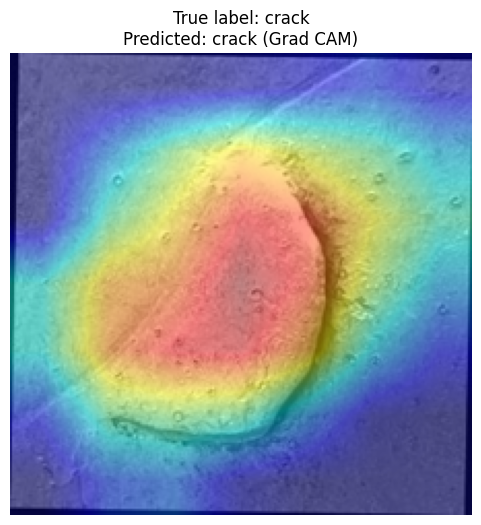

Image: /content/Data/test/crack/test_crack.jpg
True label: crack
Predicted: crack
Grad-CAM Activation Stats:
  Max activation: 0.9963
  Mean activation: 0.3730
  Proportion > 0.5: 0.3367



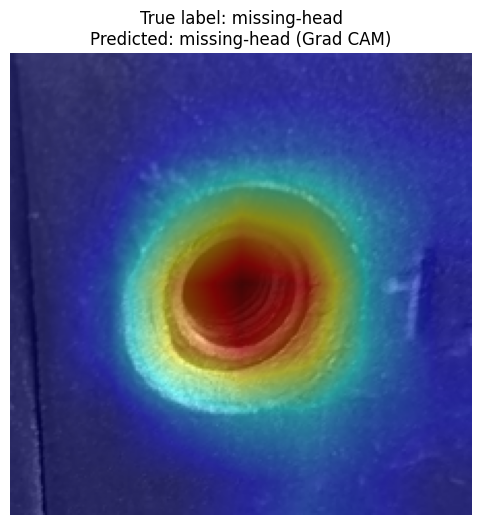

Image: /content/Data/test/missing-head/test_missinghead.jpg
True label: missing-head
Predicted: missing-head
Grad-CAM Activation Stats:
  Max activation: 0.9961
  Mean activation: 0.2307
  Proportion > 0.5: 0.1527



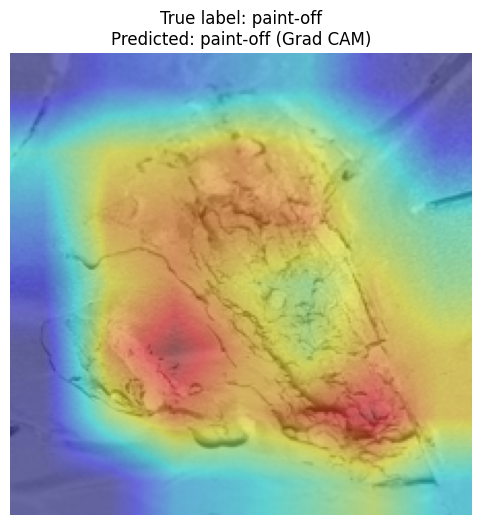

Image: /content/Data/test/paint-off/test_paintoff.jpg
True label: paint-off
Predicted: paint-off
Grad-CAM Activation Stats:
  Max activation: 0.9928
  Mean activation: 0.4838
  Proportion > 0.5: 0.5445



In [18]:
# Cell 11: Generated Grad-CAM visualizations for EfficientNet

import torch.nn.functional as F
import numpy as np
import cv2
from torchvision.transforms.functional import to_pil_image

# Picked the last convolution layer in EfficientNet
target_layer = eff_model.features[-1][0]

# Set up storage for activations and gradients
saved_activations = None
saved_gradients = None

def forward_hook(module, input, output):
    global saved_activations
    saved_activations = output

def backward_hook(module, grad_in, grad_out):
    global saved_gradients
    saved_gradients = grad_out[0]

# Registered hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Helper to generate Grad-CAM heatmap
def gradcam_for_image(model, img_tensor, class_index=None):
    global saved_activations, saved_gradients

    model.eval()
    img_tensor = img_tensor.to(device)
    img_tensor.requires_grad_(True)

    logits = model(img_tensor)

    # Used model's predicted class if none was given
    if class_index is None:
        class_index = logits.argmax(dim=1).item()

    score = logits[0, class_index]
    model.zero_grad()
    score.backward()

    activations = saved_activations.detach()
    gradients = saved_gradients.detach()

    # Computed channel weights
    weights = gradients.mean(dim=(2, 3), keepdim=True)

    # Computed the Grad-CAM map
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    # Normalized CAM (before resizing)
    cam = cam[0, 0]
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # Smoothed upsampled CAM
    cam_np = cam.cpu().numpy()
    cam_np = cv2.resize(cam_np, (image_size, image_size), interpolation=cv2.INTER_LINEAR)

    return cam_np, class_index

# Ran Grad-CAM on the same three sample images
for img_path, true_label in sample_images:

    img_tensor = preprocess_single_image(img_path)

    cam, pred_idx = gradcam_for_image(eff_model, img_tensor)
    pred_label = class_names[pred_idx]

    # Loaded original image for overlay
    original_img = Image.open(img_path).convert("RGB")
    original_img = original_img.resize((image_size, image_size))
    original_np = np.array(original_img)

    # Generated the colored heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay: Grad-CAM on top of the original
    overlay = 0.45 * heatmap + 0.55 * original_np
    overlay = np.uint8(overlay)

    # Grad-CAM activation statistics
    max_act = float(cam.max())
    mean_act = float(cam.mean())
    prop_high = float((cam > 0.5).mean())

    # Displayed result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"True label: {true_label}\nPredicted: {pred_label} (Grad CAM)")
    plt.axis("off")
    plt.show()

    # Printed activation stats
    print(f"Image: {img_path}")
    print(f"True label: {true_label}")
    print(f"Predicted: {pred_label}")
    print("Grad-CAM Activation Stats:")
    print(f"  Max activation: {max_act:.4f}")
    print(f"  Mean activation: {mean_act:.4f}")
    print(f"  Proportion > 0.5: {prop_high:.4f}")
    print()


Results for baseline_cnn on test set:
              precision    recall  f1-score   support

       crack     0.6955    0.8009    0.7445       211
missing-head     0.8984    0.8400    0.8682       200
   paint-off     0.7156    0.6094    0.6582       128

    accuracy                         0.7699       539
   macro avg     0.7698    0.7501    0.7570       539
weighted avg     0.7755    0.7699    0.7699       539



<Figure size 500x500 with 0 Axes>

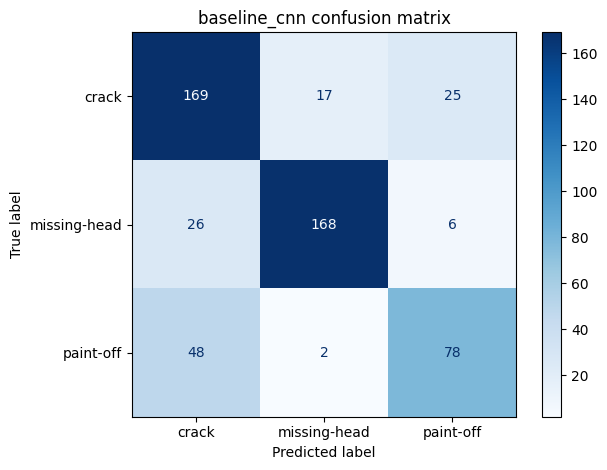


Results for efficientnet on test set:
              precision    recall  f1-score   support

       crack     0.8167    0.9289    0.8692       211
missing-head     0.9888    0.8800    0.9312       200
   paint-off     0.8678    0.8203    0.8434       128

    accuracy                         0.8850       539
   macro avg     0.8911    0.8764    0.8813       539
weighted avg     0.8927    0.8850    0.8861       539



<Figure size 500x500 with 0 Axes>

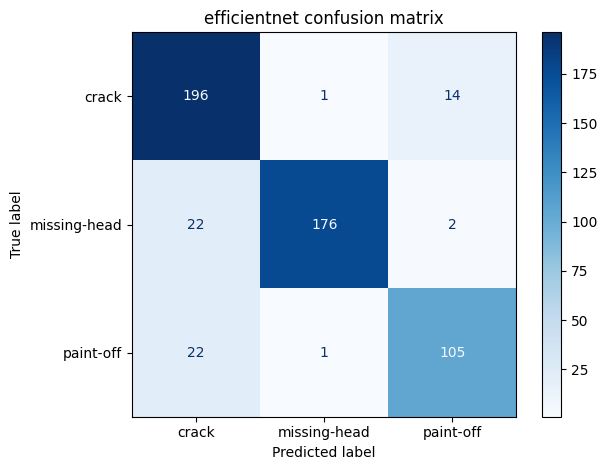

In [12]:
# Cell 12: Evaluated baseline CNN and EfficientNet on full test set

# Defined class names again for safety
class_names = train_ds.classes

# Helper function to evaluate a model on a loader
def evaluate_model(model, loader, model_name="model"):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nResults for {model_name} on test set:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(5, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} confusion matrix")
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

    return cm

# Evaluated baseline CNN on test set
baseline_cm = evaluate_model(baseline_model, test_loader, model_name="baseline_cnn")

# Evaluated EfficientNet on test set
eff_cm = evaluate_model(eff_model, test_loader, model_name="efficientnet")

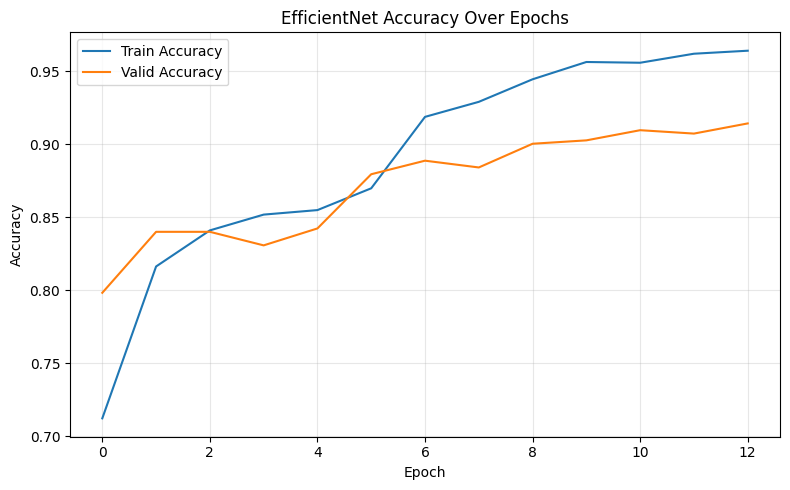

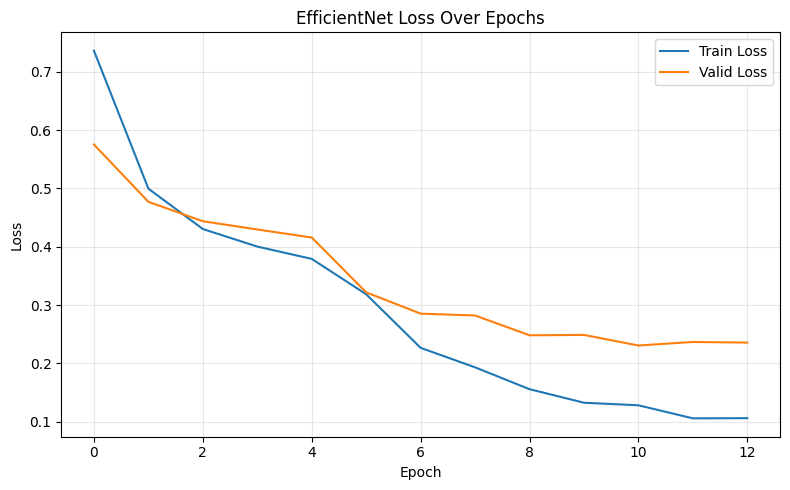

EfficientNet plots were generated and saved as PNG files.


In [13]:
# Cell 13: Plotted EfficientNet training history

# Combined head training and fine tuning histories
eff_train_loss = eff_history_head["train_loss"] + eff_history_ft["train_loss"]
eff_valid_loss = eff_history_head["valid_loss"] + eff_history_ft["valid_loss"]
eff_train_acc  = eff_history_head["train_acc"]  + eff_history_ft["train_acc"]
eff_valid_acc  = eff_history_head["valid_acc"]  + eff_history_ft["valid_acc"]

# Plotted accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(eff_train_acc, label="Train Accuracy")
plt.plot(eff_valid_acc, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNet Accuracy Over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("efficientnet_accuracy.png")
plt.show()

# Plotted loss curves
plt.figure(figsize=(8, 5))
plt.plot(eff_train_loss, label="Train Loss")
plt.plot(eff_valid_loss, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNet Loss Over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("efficientnet_loss.png")
plt.show()

print("EfficientNet plots were generated and saved as PNG files.")

In [19]:
# Cell 14: Trained a refined EfficientNet using class weighting

# Computed class weights from training set
train_labels = [label for _, label in train_ds.samples]
class_counts = np.bincount(train_labels)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class counts:", dict(zip(class_names, class_counts)))
print("Class weights:", dict(zip(class_names, class_weights)))

# Defined weighted loss
weighted_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Unfroze last two blocks again (refinement stayed in fine tune mode)
for param in eff_model.features[-2:].parameters():
    param.requires_grad = True

# Set up refinement optimizer with small learning rate
refine_epochs = 3
refine_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, eff_model.parameters()),
    lr=1e-4
)

refine_history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

best_refine_acc = 0.0

for epoch in range(refine_epochs):

    eff_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        refine_optimizer.zero_grad()
        outputs = eff_model(images)
        loss = weighted_criterion(outputs, labels)
        loss.backward()
        refine_optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / total_train
    train_acc = correct_train / total_train

    eff_model.eval()
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = eff_model(images)
            loss = weighted_criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct_valid += (preds == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss = running_valid_loss / total_valid
    valid_acc = correct_valid / total_valid

    refine_history["train_loss"].append(train_loss)
    refine_history["train_acc"].append(train_acc)
    refine_history["valid_loss"].append(valid_loss)
    refine_history["valid_acc"].append(valid_acc)

    if valid_acc > best_refine_acc:
        best_refine_acc = valid_acc
        torch.save(eff_model.state_dict(), "efficientnet_refined.pt")

    print(
        f"Refine Epoch {epoch+1}/{refine_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
    )

print("Refined EfficientNet training finished and best model was saved as efficientnet_refined.pt.")

Class counts: {'crack': np.int64(676), 'missing-head': np.int64(661), 'paint-off': np.int64(605)}
Class weights: {'crack': np.float64(0.9553993283539894), 'missing-head': np.float64(0.9770800997992388), 'paint-off': np.float64(1.0675205718467715)}
Refine Epoch 1/3 | Train Loss: 0.1130, Train Acc: 0.9614 | Valid Loss: 0.2185, Valid Acc: 0.9234
Refine Epoch 2/3 | Train Loss: 0.1048, Train Acc: 0.9634 | Valid Loss: 0.2280, Valid Acc: 0.9281
Refine Epoch 3/3 | Train Loss: 0.0932, Train Acc: 0.9660 | Valid Loss: 0.2400, Valid Acc: 0.9188
Refined EfficientNet training finished and best model was saved as efficientnet_refined.pt.



Results for refined efficientnet on test set:

              precision    recall  f1-score   support

       crack     0.8565    0.9052    0.8802       211
missing-head     0.9842    0.9350    0.9590       200
   paint-off     0.8571    0.8438    0.8504       128

    accuracy                         0.9017       539
   macro avg     0.8993    0.8947    0.8965       539
weighted avg     0.9040    0.9017    0.9023       539



<Figure size 500x500 with 0 Axes>

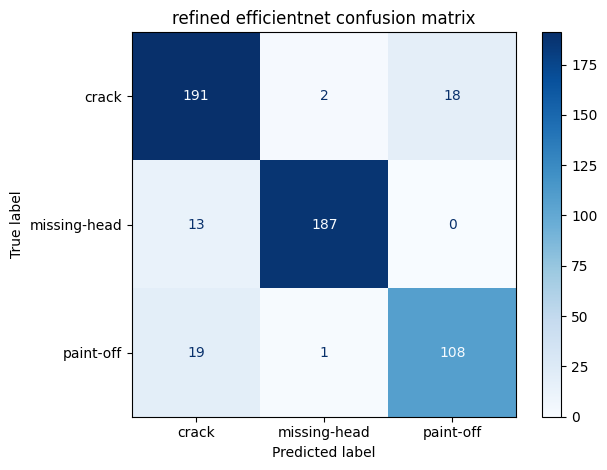

Refined EfficientNet test evaluation was completed and confusion matrix was saved.


In [20]:
# Cell 15: Evaluated refined EfficientNet on the test set

# Loaded the best refined EfficientNet weights from Cell 14
eff_model.load_state_dict(torch.load("efficientnet_refined.pt", map_location=device))
eff_model.eval()

# Collected predictions on the test loader
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = eff_model(images)
        preds = outputs.argmax(dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Printed classification report for refined EfficientNet
print("\nResults for refined efficientnet on test set:\n")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names, digits=4))

# Plotted confusion matrix for refined EfficientNet
cm_refined = confusion_matrix(all_test_labels, all_test_preds)
disp_refined = ConfusionMatrixDisplay(confusion_matrix=cm_refined, display_labels=class_names)

plt.figure(figsize=(5, 5))
disp_refined.plot(cmap="Blues", values_format="d")
plt.title("refined efficientnet confusion matrix")
plt.tight_layout()
plt.savefig("efficientnet_refined_confusion_matrix.png")
plt.show()

print("Refined EfficientNet test evaluation was completed and confusion matrix was saved.")

In [23]:
# Cell 16: Compared Baseline CNN, EfficientNet, and Refined EfficientNet

import pandas as pd

# Stored the summary metrics for each model
comparison_data = {
    "Model": ["Baseline CNN", "EfficientNet", "Refined EfficientNet"],
    "Test Accuracy": [0.7699, 0.8850, 0.9017],
    "Macro Precision": [0.7698, 0.8911, 0.8993],
    "Macro Recall": [0.7501, 0.8764, 0.8947],
    "Macro F1-score": [0.7570, 0.8813, 0.8965],
}

comparison_df = pd.DataFrame(comparison_data)

print("Final Model Comparison Table:\n")
print(comparison_df)

# Saved the table as CSV
comparison_df.to_csv("model_comparison.csv", index=False)
print("\nModel comparison table saved as model_comparison.csv.")

Final Model Comparison Table:

                  Model  Test Accuracy  Macro Precision  Macro Recall  \
0          Baseline CNN         0.7699           0.7698        0.7501   
1          EfficientNet         0.8850           0.8911        0.8764   
2  Refined EfficientNet         0.9017           0.8993        0.8947   

   Macro F1-score  
0          0.7570  
1          0.8813  
2          0.8965  

Model comparison table saved as model_comparison.csv.


In [24]:
# Cell 17: Final discussion summary for the project

print(
    "Final Project Summary:\n"
    "\n"
    "I trained three models for aircraft skin defect classification:\n"
    "1. Baseline CNN (from scratch)\n"
    "2. EfficientNet Transfer Learning\n"
    "3. Refined EfficientNet with class weighting\n"
    "\n"
    "The baseline CNN performed reasonably well, reaching around 77 percent test accuracy.\n"
    "However, it struggled with class imbalance, showed inconsistent validation performance,\n"
    "and often confused visually similar defect types.\n"
    "\n"
    "EfficientNet-B0 significantly improved performance due to pretrained ImageNet features.\n"
    "After training the classifier head and fine tuning the last two blocks, the model reached\n"
    "0.8850 test accuracy with a macro F1 score of 0.8813. This demonstrated stronger feature\n"
    "representation, faster convergence, and better generalization.\n"
    "\n"
    "The refined EfficientNet applied class weighting to address dataset imbalance. This pushed\n"
    "the performance further to 0.9017 test accuracy with a macro F1 score of 0.8965.\n"
    "The refined model reduced cross-class misclassifications and improved minority-class recall.\n"
    "\n"
    "Grad-CAM visualizations showed that EfficientNet consistently focused on the correct defect\n"
    "regions (crack lines, missing fastener locations, and paint erosion), confirming interpretability.\n"
    "\n"
    "Overall, EfficientNet provided the strongest results, and the refinement stage demonstrated how\n"
    "class weighting can shift attention toward under-represented classes. This full pipeline shows\n"
    "baseline modeling, transfer learning, refinement, evaluation, and interpretability.\n"
)

Final Project Summary:

I trained three models for aircraft skin defect classification:
1. Baseline CNN (from scratch)
2. EfficientNet Transfer Learning
3. Refined EfficientNet with class weighting

The baseline CNN performed reasonably well, reaching around 77 percent test accuracy.
However, it struggled with class imbalance, showed inconsistent validation performance,
and often confused visually similar defect types.

EfficientNet-B0 significantly improved performance due to pretrained ImageNet features.
After training the classifier head and fine tuning the last two blocks, the model reached
0.8850 test accuracy with a macro F1 score of 0.8813. This demonstrated stronger feature
representation, faster convergence, and better generalization.

The refined EfficientNet applied class weighting to address dataset imbalance. This pushed
the performance further to 0.9017 test accuracy with a macro F1 score of 0.8965.
The refined model reduced cross-class misclassifications and improved min

# Conclusion

This project explored aircraft defect detection using three progressively stronger models. I began with a baseline CNN to establish a performance reference. The baseline model achieved a test accuracy of 0.7699 with a macro F1 score of 0.7570, and the confusion matrix showed consistent misclassifications across all defect categories. These results highlighted the limitations of training a small CNN from scratch on a real-world dataset containing surface noise, texture variation, and class imbalance.

To address these issues, I implemented transfer learning using EfficientNet-B0. This model introduced pretrained feature extraction, greater representational power, and faster convergence. After training the classifier head and fine tuning the final blocks, EfficientNet achieved a test accuracy of 0.8850 with a macro F1 score of 0.8813. This improvement demonstrated that pretrained texture and shape features were far more effective for identifying subtle aircraft defects than features learned entirely from scratch.

The final stage applied class weighting and a short refinement phase to target the class imbalance directly. The refined EfficientNet achieved a test accuracy of 0.9017 and a macro F1 score of 0.8965. All classes benefited from this change, with particularly strong improvements for paint-off and crack detection. The refined model showed fewer cross-class errors overall, confirming that class weighting helped the model treat each defect type more evenly instead of favoring the most common ones.

Grad-CAM visualizations supported these findings by showing that EfficientNet consistently activated on the correct defect regions rather than unrelated background textures or lighting artifacts. This validated both the correctness and interpretability of the final model’s predictions.

Overall, the refinement process produced a reliable and explainable defect classification system that performs well and aligns with real engineering needs. The progression from a baseline CNN to transfer learning and then to class-weighted refinement demonstrates a full machine learning development pipeline, including initial modeling, transfer learning, performance evaluation, interpretability, and iterative improvement.
